<h1> Code for bengali digits recognition from an image  </h1>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
import numpy as np
import cv2

<h4>loading the training and testing data. the data is in form of .npz format which consisits of 2 files : 
  'images' and 'labels'</h4> 

In [2]:
training = np.load('training-images.npz')
y_train = training['labels']
x_train = training['images']

testing = np.load('testing-images.npz')
x_test= testing['images']
y_test = testing['labels']

In [3]:
print(x_train.shape)

(5000, 32, 32, 3)


# Image normalization
<h4>In order to reduce the computation of the CNN model that we have normalized the image by dividing all the pixels by the maximum size which is 255. This doesn't affect the actual image as can be shown by plotting the image before and after normalization. </h4>

In [4]:
x_train = x_train/255.0
x_test = x_test/255.0

<h1> BUilding a KERAS sequential model</h1>

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size = 3, padding = "same", activation = "relu", input_shape = [32,32,3]),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

# Compiling model
with reference to the [ https://medium.com/@onlytojay/mnist-cnn-optimizer-comparison-with-tensorflow-keras-163735862ecd] adam optimiser was decided  .

In [6]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="Adam", metrics=["sparse_categorical_accuracy"])

# Defining a Callback
the callback class is useful to terminate the training process whenever the desired threshold is reached. We intend to stop the training process when the accuracy goes beyond 0.99. 

In [7]:
ACCURACY_THRESHOLD = 0.99
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs= {}):
        if (logs.get('sparse_categorical_accuracy')> ACCURACY_THRESHOLD ):
            print("\n Reached 99% accuracy, so cancelling training!")
            self.model.stop_training = True
            
            
callbacks = myCallback()

# Training the model


In [8]:
model.fit(x_train, y_train, epochs = 10, callbacks = [callbacks])

Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 16s 3ms/sample - loss: 0.5477 - sparse_categorical_accuracy: 0.8228
Epoch 2/10
5000/5000 [==============================] - 3s 619us/sample - loss: 0.1246 - sparse_categorical_accuracy: 0.9588
Epoch 3/10
5000/5000 [==============================] - 3s 614us/sample - loss: 0.0710 - sparse_categorical_accuracy: 0.9784
Epoch 4/10
5000/5000 [==============================] - 3s 614us/sample - loss: 0.0415 - sparse_categorical_accuracy: 0.9874
Epoch 5/10
4928/5000 [============================>.] - ETA: 0s - loss: 0.0304 - sparse_categorical_accuracy: 0.9901
 Reached 99% accuracy, so cancelling training!
5000/5000 [==============================] - 3s 614us/sample - loss: 0.0306 - sparse_categorical_accuracy: 0.9900


In [9]:
# As our model is trained now, lets get to our image

# Image preprocessing

(514, 1181, 3)


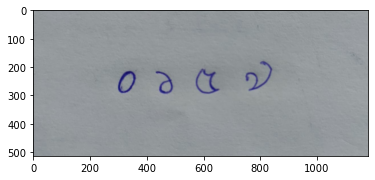

In [66]:
# read the image 
image = cv2.imread("rgb.jpeg") 
img = image.copy()
plt.imshow(image, cmap="gray")
print(img.shape)


<h3> Defining Image binarization function  </h3>

In [67]:
def binarize(image):
    # convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # create a binary thresholded image
    _, binary = cv2.threshold(gray, 110, 225, cv2.THRESH_BINARY_INV)

    return binary



now we take the reference image ; binarise it and save it for further use as 'bin.jpg'. we will be using this image after we find the contours of digits, for digits extraction.

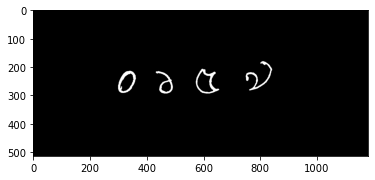

In [68]:
binary = binarize(image)
#
plt.imshow(binary, cmap="gray") # plotting the binarised image
plt.imsave('bin.jpg',binary,cmap = "gray") # saving the binarised image

#finding contours
some major part of the code below was reffered from the openCV documentations on contour features[https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html]

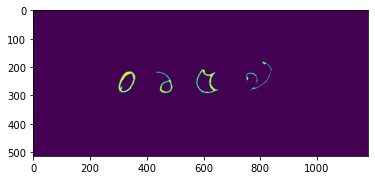

In [69]:
# find the contours from the thresholded image
contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE) 

# draw all contours
image = cv2.drawContours(binary, contours, -1, (0, 255, 0), 2)
plt.imshow(image)# show the image with the drawn contours
plt.show()

<h3>these contours are saved in a vector  'contours'</h3>

In [70]:

len(contours)


4

<h4>conversion of binarised image (that we saved earlier as bin.jpg) such that all black pixels turn white and vice versa using bitwise_not.
the image obtained from this operation will be used further to extract the bounding rectangles from it.</h4>

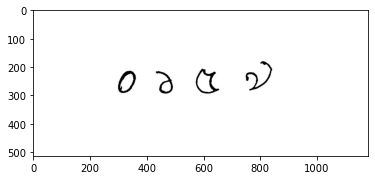

In [71]:

binr = cv2.imread('bin.jpg')
binr = cv2.bitwise_not(binr)
plt.imshow(binr)
#binr

# The following loop performs 3 tasks as follows:        
<h3>[1] using the contours vector extract each digit image in form of a <h3>bounding    rectangle where (x,y) are coordinates of top left corner pixel of<h3> this rectangle and  w , h are width and height of the rectangle.  </h3>     
<h3>[2] resize these images to the same size as training images. </h3>           
<h3>[3] prediction of the digit matching with that image</h3>


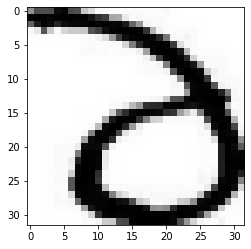

Predicted value: 1


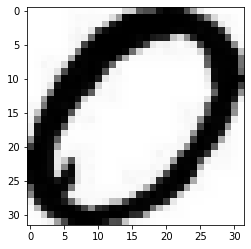

Predicted value: 0


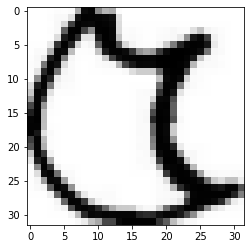

Predicted value: 5


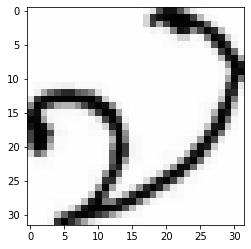

Predicted value: 9


In [72]:
ans = []
image_name = 0
x1,y1 = 0,0

for i in range(len(contours)):
    image_name += 1
    cnt = contours[i]                     
    x,y,w,h = cv2.boundingRect(cnt)      # extracting specifications of the bounding rectangle.
    segmented_image=binr[y:y+h,x:x+w]    # extracting this bounding rectangle form the binr image.
    
    # resizing the segmented images
    if abs(x1 - x) > 0.5 and abs(y-y1) > 0.5:
        if h >= 30 and w >= 30:
            segmented_image = resize(abs(segmented_image), (32,32))
            plt.imshow(segmented_image)
            plt.show()
            cv2.imwrite(str(image_name) + '.jpg',segmented_image)
            
    x1,y1 = x,y


    # image prediction
    op = model.predict_classes(tf.reshape((segmented_image),[1,32,32,3]))    
    ans.append(op[0])
    print(f'Predicted value: {op[0]}')

In [76]:
print(f"The predicted values are {ans}")

The predicted values are [1, 0, 5, 9]
